# About this notebook
- Deberta-v3-large starter code
- pip wheels is [here](https://www.kaggle.com/code/yasufuminakama/pppm-pip-wheels)
- Inference notebook is [here](https://www.kaggle.com/code/yasufuminakama/pppm-deberta-v3-large-baseline-inference)

If this notebook is helpful, feel free to upvote :)

In [1]:
import os
import time

wait_to_make = "trained_list/deberta-kfskyAttention.txt"
count = 0
while 1:
    if os.path.exists(wait_to_make):
        break
    print(f'sleep {count} h')
    time.sleep(3600)
    count+=1
    


In [2]:
_mixout = 0.9
EXP_NAME = f"microsoft-deberta-large-v3-large-kfskyAttention-multido-cat3"


In [3]:
# !nvidia-smi
! pip install torch==1.9.0+cu111 torchvision==0.10.0+cu111 torchaudio===0.9.0 -f https://download.pytorch.org/whl/torch_stable.html

Looking in links: https://download.pytorch.org/whl/torch_stable.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 GB 2.4 MB/s eta 0:00:00:00:0100:02
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.2/23.2 MB 36.5 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 18.6 MB/s eta 0:00:00a 0:00:01
  Attempting uninstall: torch
    Found existing installation: torch 1.9.1+cpu
    Uninstalling torch-1.9.1+cpu:
      Successfully uninstalled torch-1.9.1+cpu
  Attempting uninstall: torchvision
    Found existing installation: torchvision 0.10.1+cpu
    Uninstalling torchvision-0.10.1+cpu:
      Successfully uninstalled torchvision-0.10.1+cpu
  Attempting uninstall: torchaudio
    Found existing installation: torchaudio 0.9.1
    Uninstalling torchaudio-0.9.1:
      Successfully uninstalled torchaudio-0.9.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the follo

In [4]:
import torch
print(torch.__version__)
print(torch.cuda.is_available())

1.9.0+cu111
True


# Directory settings

In [5]:
# ====================================================
# Directory settings
# ====================================================

import os
import datetime

INPUT_DIR = '../../data/us-patent-phrase-to-phrase-matching/'
dt_now = datetime.datetime.now()

date = dt_now.strftime('%Y-%m-%d-%H-%M-%S')
 
OUTPUT_DIR = f'./output/{EXP_NAME}/'
# if not os.path.exists(OUTPUT_DIR):
os.makedirs(OUTPUT_DIR, exist_ok=True)


# CFG

In [6]:
# ====================================================
# CFG
# ====================================================
class CFG:
    wandb=False
    competition='PPPM'
    _wandb_kernel='nakama'
    debug=False
    apex=True
    print_freq=100
    num_workers=4
    # model="microsoft/deberta-v3-large"
    model = "microsoft/deberta-v3-large"
    # size = "large
    # model = f"{model}-{size}"
    if "small" in model:
        hidden_state = hiddden_state_fix = 512
    elif "base" in model:
        hidden_state = hiddden_state_fix = 768
    elif "large" in model:
        hidden_state = hiddden_state_fix = 1024
    elif "xlarge" in model:
        hidden_state =  1536
        
    scheduler='cosine' # ['linear', 'cosine']
    batch_scheduler=True
    num_cycles=0.5
    num_warmup_steps=0
    epochs=6
    encoder_lr=2e-5
    decoder_lr=2e-5
    min_lr=1e-6
    eps=1e-6
    betas=(0.9, 0.999)
    
    batch_size=8
    mixout = True
    mixout_prob = _mixout
    pass_fold = [0,1]
    
    
    fc_dropout=0.2
    target_size=1
    max_len=512
    weight_decay=0.01
    gradient_accumulation_steps=1
    max_grad_norm=1000
    seed=42
    n_fold=4
    trn_fold=[i for i in range(n_fold)]
    train=True
    
if CFG.debug:
    CFG.epochs = 2
    CFG.trn_fold = [0]

In [7]:
# ====================================================
# wandb
# ====================================================
if CFG.wandb:
    
    import wandb

    try:
        from kaggle_secrets import UserSecretsClient
        user_secrets = UserSecretsClient()
        secret_value_0 = user_secrets.get_secret("wandb_api")
        wandb.login(key=secret_value_0)
        anony = None
    except:
        anony = "must"
        print('If you want to use your W&B account, go to Add-ons -> Secrets and provide your W&B access token. Use the Label name as wandb_api. \nGet your W&B access token from here: https://wandb.ai/authorize')


    def class2dict(f):
        return dict((name, getattr(f, name)) for name in dir(f) if not name.startswith('__'))

    run = wandb.init(project='PPPM-Public', 
                     name=CFG.model,
                     config=class2dict(CFG),
                     group=CFG.model,
                     job_type="train",
                     anonymous=anony)

In [8]:
# !pip install transformers==4.16.2
# !pip install tokenizers==0.11.0

# Library

In [9]:
# ====================================================
# Library
# ====================================================
import os
import gc
import re
import ast
import sys
import copy
import json
import time
import math
import shutil
import string
import pickle
import random
import joblib
import itertools
from pathlib import Path
import warnings
warnings.filterwarnings("ignore")

import scipy as sp
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
from tqdm.auto import tqdm
from sklearn.metrics import f1_score
from sklearn.model_selection import StratifiedKFold, GroupKFold, KFold

import torch
print(f"torch.__version__: {torch.__version__}")
import torch.nn as nn
from torch.nn import Parameter
import torch.nn.functional as F
from torch.optim import Adam, SGD, AdamW
from torch.utils.data import DataLoader, Dataset

import tokenizers
import transformers
print(f"tokenizers.__version__: {tokenizers.__version__}")
print(f"transformers.__version__: {transformers.__version__}")
from transformers import AutoTokenizer, AutoModel, AutoConfig,AutoModelForTokenClassification,AutoModelForSequenceClassification
from transformers import get_linear_schedule_with_warmup, get_cosine_schedule_with_warmup
%env TOKENIZERS_PARALLELISM=true

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

start = time.time()

torch.__version__: 1.9.0+cu111
tokenizers.__version__: 0.11.6
transformers.__version__: 4.17.0
env: TOKENIZERS_PARALLELISM=true
cuda


# Utils

In [10]:
# ====================================================
# Utils
# ====================================================
def get_score(y_true, y_pred):
    score = sp.stats.pearsonr(y_true, y_pred)[0]
    return score


def get_logger(filename=OUTPUT_DIR+'train'):
    if os.path.exists(filename):
        os.remove(filename)
    from logging import getLogger, INFO, StreamHandler, FileHandler, Formatter
    logger = getLogger(__name__)
    logger.setLevel(INFO)
    handler1 = StreamHandler()
    handler1.setFormatter(Formatter("%(message)s"))
    handler2 = FileHandler(filename=f"{filename}.log")
    handler2.setFormatter(Formatter("%(message)s"))
    logger.addHandler(handler1)
    logger.addHandler(handler2)
    return logger

LOGGER = get_logger()

def seed_everything(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    
seed_everything(seed=42)

# Data Loading

In [11]:
# ====================================================
# Data Loading
# ====================================================
train = pd.read_csv(INPUT_DIR+'train.csv')
test = pd.read_csv(INPUT_DIR+'test.csv')
submission = pd.read_csv(INPUT_DIR+'sample_submission.csv')
print(f"train.shape: {train.shape}")
print(f"test.shape: {test.shape}")
print(f"submission.shape: {submission.shape}")
display(train.head())
display(test.head())
display(submission.head())

train.shape: (36473, 5)
test.shape: (36, 4)
submission.shape: (36, 2)


,id,anchor,target,context,score
0,37d61fd2272659b1,abatement,abatement of pollution,A47,0.50
1,7b9652b17b68b7a4,abatement,act of abating,A47,0.75
2,36d72442aefd8232,abatement,active catalyst,A47,0.25
3,5296b0c19e1ce60e,abatement,eliminating process,A47,0.50
4,54c1e3b9184cb5b6,abatement,forest region,A47,0.00


,id,anchor,target,context
0,4112d61851461f60,opc drum,inorganic photoconductor drum,G02
1,09e418c93a776564,adjust gas flow,altering gas flow,F23
2,36baf228038e314b,lower trunnion,lower locating,B60
3,1f37ead645e7f0c8,cap component,upper portion,D06
4,71a5b6ad068d531f,neural stimulation,artificial neural network,H04


,id,score
0,4112d61851461f60,0
1,09e418c93a776564,0
2,36baf228038e314b,0
3,1f37ead645e7f0c8,0
4,71a5b6ad068d531f,0


In [12]:
# ====================================================
# CPC Data
# ====================================================
def get_cpc_texts():
    contexts = []
    pattern = '[A-Z]\d+'
    for file_name in os.listdir(INPUT_DIR+'CPCSchemeXML202105'):
        result = re.findall(pattern, file_name)
        if result:
            contexts.append(result)
    contexts = sorted(set(sum(contexts, [])))
    results = {}
    for cpc in ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'Y']:
        with open(f'{INPUT_DIR}CPCTitleList202202/cpc-section-{cpc}_20220201.txt') as f:
            s = f.read()
        pattern = f'{cpc}\t\t.+'
        result = re.findall(pattern, s)
        cpc_result = result[0].lstrip(pattern)
        for context in [c for c in contexts if c[0] == cpc]:
            pattern = f'{context}\t\t.+'
            result = re.findall(pattern, s)
            results[context] = cpc_result + ". " + result[0].lstrip(pattern)
    return results


# cpc_texts = get_cpc_texts()
# torch.save(cpc_texts, OUTPUT_DIR+"cpc_texts.pth")
cpc_texts = torch.load(INPUT_DIR+"cpc_texts.pth")
train['context_text'] = train['context'].map(cpc_texts)
test['context_text'] = test['context'].map(cpc_texts)
display(train.head())
display(test.head())

,id,anchor,target,context,score,context_text
0,37d61fd2272659b1,abatement,abatement of pollution,A47,0.50,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...
1,7b9652b17b68b7a4,abatement,act of abating,A47,0.75,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...
2,36d72442aefd8232,abatement,active catalyst,A47,0.25,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...
3,5296b0c19e1ce60e,abatement,eliminating process,A47,0.50,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...
4,54c1e3b9184cb5b6,abatement,forest region,A47,0.00,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...


,id,anchor,target,context,context_text
0,4112d61851461f60,opc drum,inorganic photoconductor drum,G02,PHYSICS. OPTICS
1,09e418c93a776564,adjust gas flow,altering gas flow,F23,MECHANICAL ENGINEERING; LIGHTING; HEATING; WEA...
2,36baf228038e314b,lower trunnion,lower locating,B60,PERFORMING OPERATIONS; TRANSPORTING. VEHICLES ...
3,1f37ead645e7f0c8,cap component,upper portion,D06,TEXTILES; PAPER. TREATMENT OF TEXTILES OR THE ...
4,71a5b6ad068d531f,neural stimulation,artificial neural network,H04,ELECTRICITY. ELECTRIC COMMUNICATION TECHNIQUE


In [13]:
pad = "[SEP]"
train['text'] = train['anchor'] + pad + train['target'] +pad  + train['context_text']
test['text'] = test['anchor'] + pad + test['target'] +pad  + test['context_text']
display(train.head())
display(test.head())

,id,anchor,target,context,score,context_text,text
0,37d61fd2272659b1,abatement,abatement of pollution,A47,0.50,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...,abatement[SEP]abatement of pollution[SEP]HUMAN...
1,7b9652b17b68b7a4,abatement,act of abating,A47,0.75,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...,abatement[SEP]act of abating[SEP]HUMAN NECESSI...
2,36d72442aefd8232,abatement,active catalyst,A47,0.25,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...,abatement[SEP]active catalyst[SEP]HUMAN NECESS...
3,5296b0c19e1ce60e,abatement,eliminating process,A47,0.50,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...,abatement[SEP]eliminating process[SEP]HUMAN NE...
4,54c1e3b9184cb5b6,abatement,forest region,A47,0.00,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...,abatement[SEP]forest region[SEP]HUMAN NECESSIT...


,id,anchor,target,context,context_text,text
0,4112d61851461f60,opc drum,inorganic photoconductor drum,G02,PHYSICS. OPTICS,opc drum[SEP]inorganic photoconductor drum[SEP...
1,09e418c93a776564,adjust gas flow,altering gas flow,F23,MECHANICAL ENGINEERING; LIGHTING; HEATING; WEA...,adjust gas flow[SEP]altering gas flow[SEP]MECH...
2,36baf228038e314b,lower trunnion,lower locating,B60,PERFORMING OPERATIONS; TRANSPORTING. VEHICLES ...,lower trunnion[SEP]lower locating[SEP]PERFORMI...
3,1f37ead645e7f0c8,cap component,upper portion,D06,TEXTILES; PAPER. TREATMENT OF TEXTILES OR THE ...,cap component[SEP]upper portion[SEP]TEXTILES; ...
4,71a5b6ad068d531f,neural stimulation,artificial neural network,H04,ELECTRICITY. ELECTRIC COMMUNICATION TECHNIQUE,neural stimulation[SEP]artificial neural netwo...


# EDA

<AxesSubplot:>

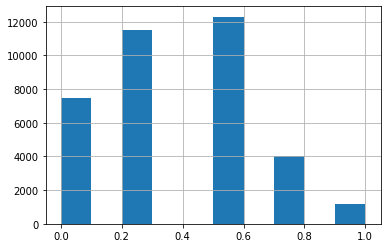

In [14]:
train['score'].hist()

In [15]:
display(train['context'].apply(lambda x: x[0]).value_counts())

B    8019
H    6195
G    6013
C    5288
A    4094
F    4054
E    1531
D    1279
Name: context, dtype: int64

- Y is not in training data, but may be in test data?

# CV split

In [16]:
# ====================================================
# CV split
# ====================================================
train['score_map'] = train['score'].map({0.00: 0, 0.25: 1, 0.50: 2, 0.75: 3, 1.00: 4})
Fold = StratifiedKFold(n_splits=CFG.n_fold, shuffle=True, random_state=CFG.seed)
for n, (train_index, val_index) in enumerate(Fold.split(train, train['score_map'])):
    train.loc[val_index, 'fold'] = int(n)
train['fold'] = train['fold'].astype(int)
display(train.groupby('fold').size())

fold
0    9119
1    9118
2    9118
3    9118
dtype: int64

In [17]:
if CFG.debug:
    display(train.groupby('fold').size())
    train = train.sample(n=1000, random_state=0).reset_index(drop=True)
    display(train.groupby('fold').size())

# tokenizer

In [18]:
# !pip install --no-cache-dir sentencepiece

In [19]:
# ====================================================
# tokenizer
# ====================================================
# tokenizer = AutoTokenizer.from_pretrained(CFG.model,use_fast=False)
tokenizer = AutoTokenizer.from_pretrained(CFG.model,use_fast=False)
tokenizer.save_pretrained(OUTPUT_DIR+'tokenizer/')
CFG.tokenizer = tokenizer



Downloading:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/580 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.35M [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


# Dataset

In [20]:
# ====================================================
# Define max_len
# ====================================================
lengths_dict = {}

lengths = []
tk0 = tqdm(cpc_texts.values(), total=len(cpc_texts))
for text in tk0:
    length = len(tokenizer(text, add_special_tokens=False)['input_ids'])
    lengths.append(length)
lengths_dict['context_text'] = lengths

for text_col in ['anchor', 'target']:
    lengths = []
    tk0 = tqdm(train[text_col].fillna("").values, total=len(train))
    for text in tk0:
        length = len(tokenizer(text, add_special_tokens=False)['input_ids'])
        lengths.append(length)
    lengths_dict[text_col] = lengths
    
CFG.max_len = max(lengths_dict['anchor']) + max(lengths_dict['target'])\
                + max(lengths_dict['context_text']) + 4 # CLS + SEP + SEP + SEP
LOGGER.info(f"max_len: {CFG.max_len}")

  0%|          | 0/136 [00:00<?, ?it/s]

  0%|          | 0/36473 [00:00<?, ?it/s]

  0%|          | 0/36473 [00:00<?, ?it/s]

max_len: 133


In [21]:
# ====================================================
# Dataset
# ====================================================
def prepare_input(cfg, text):
    inputs = cfg.tokenizer(text,
                           add_special_tokens=True,
                           max_length=cfg.max_len,
                           padding="max_length",
                           return_offsets_mapping=False)
    for k, v in inputs.items():
        inputs[k] = torch.tensor(v, dtype=torch.long)
    return inputs

sys.path.append('../dataset')
from dataset import TrainDataset


torch.__version__: 1.9.0+cu111


In [22]:
"""
train_dataset = TrainDataset(CFG, train)
inputs, label = train_dataset[0]
print(inputs)
print(label)
"""

'\ntrain_dataset = TrainDataset(CFG, train)\ninputs, label = train_dataset[0]\nprint(inputs)\nprint(label)\n'

# Model

In [23]:
class CustomModel(nn.Module):
    def __init__(self, cfg, config_path=None, pretrained=False):
        super().__init__()
        self.cfg = cfg
        
        if config_path is None:
            self.config = AutoConfig.from_pretrained(cfg.model, output_hidden_states=True)
        else:
            self.config = torch.load(config_path)
        if pretrained:
            self.model = AutoModel.from_pretrained(cfg.model, config=self.config)
        else:
            self.model = AutoModel.from_config(self.config)
        self.fc_dropout1 = nn.Dropout(cfg.fc_dropout)
        self.fc_dropout2 = nn.Dropout(cfg.fc_dropout)
        self.fc_dropout3 = nn.Dropout(cfg.fc_dropout)
        self.fc_dropout4 = nn.Dropout(cfg.fc_dropout)
        self.fc_dropout5 = nn.Dropout(cfg.fc_dropout)
        
        self.fc = nn.Linear(self.config.hidden_size*3, self.cfg.target_size)
        self._init_weights(self.fc)
        # self.attention = nn.Sequential(
        #     nn.Linear(self.config.hidden_size, 512),
        #     nn.Tanh(),
        #     nn.Linear(512, 1),
        #     nn.Softmax(dim=1)
        # )
        self.attention = nn.Sequential( 
            nn.Linear(self.config.hidden_size, self.config.hidden_size), 
            nn.LayerNorm(self.config.hidden_size), 
            nn.GELU(), 
            nn.Linear(self.config.hidden_size, 1), 
            nn.Softmax(dim=1) 
        )
        self._init_weights(self.attention)
        
        
    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            module.weight.data.normal_(mean=0.0, std=self.config.initializer_range)
            if module.bias is not None:
                module.bias.data.zero_()
        elif isinstance(module, nn.Embedding):
            module.weight.data.normal_(mean=0.0, std=self.config.initializer_range)
            if module.padding_idx is not None:
                module.weight.data[module.padding_idx].zero_()
        elif isinstance(module, nn.LayerNorm):
            module.bias.data.zero_()
            module.weight.data.fill_(1.0)
        
    def feature(self, inputs):
        outputs = self.model(**inputs)
        last_hidden_states = outputs[0]
        
        # feature = torch.mean(last_hidden_states, 1)
        weights = self.attention(last_hidden_states)
        feature = torch.sum(weights * last_hidden_states, dim=1)
        return feature

    def forward(self, inputs):
        feature = self.feature(inputs)
        feature = torch.cat([self.fc_dropout1(feature), self.fc_dropout2(feature), self.fc_dropout3(feature)], dim=1)
        # feature = (self.fc_dropout1(feature)+self.fc_dropout2(feature)+self.fc_dropout3(feature)+self.fc_dropout4(feature)+self.fc_dropout5(feature))/5
        output = self.fc(feature)
        return output

In [24]:
# class CustomModel(nn.Module):
#     def __init__(self, cfg, config_path=None, pretrained=False):
#         super().__init__()
#         self.cfg = cfg
        
#         if config_path is None:
#             self.config = AutoConfig.from_pretrained(cfg.model, output_hidden_states=True)
#         else:
#             self.config = torch.load(config_path)
#         if pretrained:
#             self.model = AutoModel.from_pretrained(cfg.model, config=self.config)
#         else:
#             self.model = AutoModel.from_config(self.config)
#         self.fc_dropout = nn.Dropout(cfg.fc_dropout)
#         self.fc = nn.Linear(self.config.hidden_size, self.cfg.target_size)
#         self._init_weights(self.fc)
#         self.attention = nn.Sequential(
#             nn.Linear(self.config.hidden_size, 512),
#             nn.Tanh(),
#             nn.Linear(512, 1),
#             nn.Softmax(dim=1)
#         )
#         self._init_weights(self.attention)
        
        
#     def _init_weights(self, module):
#         if isinstance(module, nn.Linear):
#             module.weight.data.normal_(mean=0.0, std=self.config.initializer_range)
#             if module.bias is not None:
#                 module.bias.data.zero_()
#         elif isinstance(module, nn.Embedding):
#             module.weight.data.normal_(mean=0.0, std=self.config.initializer_range)
#             if module.padding_idx is not None:
#                 module.weight.data[module.padding_idx].zero_()
#         elif isinstance(module, nn.LayerNorm):
#             module.bias.data.zero_()
#             module.weight.data.fill_(1.0)
        
#     def feature(self, inputs):
#         outputs = self.model(**inputs)
#         last_hidden_states = outputs[0]
        
#         # feature = torch.mean(last_hidden_states, 1)
#         weights = self.attention(last_hidden_states)
#         feature = torch.sum(weights * last_hidden_states, dim=1)
#         return feature

#     def forward(self, inputs):
#         feature = self.feature(inputs)
#         output = self.fc(self.fc_dropout(feature))
#         return output

# Helpler functions

In [25]:
# ====================================================
# Helper functions
# ====================================================
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (remain %s)' % (asMinutes(s), asMinutes(rs))


def train_fn(fold, train_loader, model, criterion, optimizer, epoch, scheduler, device):
    if "train" in EXP_NAME:
        for sup_module in model.modules():
            for name, module in sup_module.named_children():
                if isinstance(module, nn.Dropout):
                    module.p = 0.0
                if isinstance(module, nn.Linear):
                    target_state_dict = module.state_dict()
                    bias = True if module.bias is not None else False
                    new_module = MixLinear(
                        module.in_features, module.out_features, bias, target_state_dict["weight"], CFG.mixout_prob
                    )
                    new_module.load_state_dict(target_state_dict)
                    setattr(sup_module, name, new_module)

        model.to(device)                
    model.train()
    scaler = torch.cuda.amp.GradScaler(enabled=CFG.apex)
    losses = AverageMeter()
    start = end = time.time()
    global_step = 0
    for step, (inputs, labels) in enumerate(train_loader):
        for k, v in inputs.items():
            inputs[k] = v.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)
        with torch.cuda.amp.autocast(enabled=CFG.apex):
            y_preds = model(inputs)
        loss = criterion(torch.squeeze(y_preds, 1), labels)
        if CFG.gradient_accumulation_steps > 1:
            loss = loss / CFG.gradient_accumulation_steps
        losses.update(loss.item(), batch_size)
        scaler.scale(loss).backward()
        grad_norm = torch.nn.utils.clip_grad_norm_(model.parameters(), CFG.max_grad_norm)
        if (step + 1) % CFG.gradient_accumulation_steps == 0:
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad()
            global_step += 1
            if CFG.batch_scheduler:
                scheduler.step()
        end = time.time()
        if step % CFG.print_freq == 0 or step == (len(train_loader)-1):
            print('Epoch: [{0}][{1}/{2}] '
                  'Elapsed {remain:s} '
                  'Loss: {loss.val:.4f}({loss.avg:.4f}) '
                  'Grad: {grad_norm:.4f}  '
                  'LR: {lr:.8f}  '
                  .format(epoch+1, step, len(train_loader), 
                          remain=timeSince(start, float(step+1)/len(train_loader)),
                          loss=losses,
                          grad_norm=grad_norm,
                          lr=scheduler.get_lr()[0]))
        if CFG.wandb:
            wandb.log({f"[fold{fold}] loss": losses.val,
                       f"[fold{fold}] lr": scheduler.get_lr()[0]})
    return losses.avg


def valid_fn(valid_loader, model, criterion, device):
    losses = AverageMeter()
    model.eval()
    preds = []
    start = end = time.time()
    for step, (inputs, labels) in enumerate(valid_loader):
        for k, v in inputs.items():
            inputs[k] = v.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)
        with torch.no_grad():
            y_preds = model(inputs)
        loss = criterion(torch.squeeze(y_preds,1), labels)
        if CFG.gradient_accumulation_steps > 1:
            loss = loss / CFG.gradient_accumulation_steps
        losses.update(loss.item(), batch_size)
        preds.append(y_preds.sigmoid().to('cpu').numpy())
        end = time.time()
        if step % CFG.print_freq == 0 or step == (len(valid_loader)-1):
            print('EVAL: [{0}/{1}] '
                  'Elapsed {remain:s} '
                  'Loss: {loss.val:.4f}({loss.avg:.4f}) '
                  .format(step, len(valid_loader),
                          loss=losses,
                          remain=timeSince(start, float(step+1)/len(valid_loader))))
    predictions = np.concatenate(preds)
    predictions = np.concatenate(predictions)
    return losses.avg, predictions


def inference_fn(test_loader, model, device):
    preds = []
    model.eval()
    model.to(device)
    tk0 = tqdm(test_loader, total=len(test_loader))
    for inputs in tk0:
        for k, v in inputs.items():
            inputs[k] = v.to(device)
        with torch.no_grad():
            y_preds = model(inputs)
        preds.append(y_preds.sigmoid().to('cpu').numpy())
    predictions = np.concatenate(preds)
    return predictions

In [26]:
# ====================================================
# train loop
# ====================================================
# def train_loop(folds, fold):
def train_loop(train_loader, valid_loader):

    # ====================================================
    # model & optimizer
    # ====================================================
    if "transformer" in EXP_NAME:
        model = CustomModelTransformer(CFG, config_path=None, pretrained=True)
    else:
        model = CustomModel(CFG, config_path=None, pretrained=True)
    if "all" in EXP_NAME:
        for sup_module in model.modules():
            for name, module in sup_module.named_children():
                if isinstance(module, nn.Dropout):
                    module.p = 0.0
                if isinstance(module, nn.Linear):
                    target_state_dict = module.state_dict()
                    bias = True if module.bias is not None else False
                    new_module = MixLinear(
                        module.in_features, module.out_features, bias, target_state_dict["weight"], CFG.mixout_prob
                    )
                    new_module.load_state_dict(target_state_dict)
                    setattr(sup_module, name, new_module)
    model.to(device)
                
    torch.save(model.config, OUTPUT_DIR+'config.pth')
    
    def get_optimizer_params(model, encoder_lr, decoder_lr, weight_decay=0.0):
        param_optimizer = list(model.named_parameters())
        no_decay = ["bias", "LayerNorm.bias", "LayerNorm.weight"]
        optimizer_parameters = [
            {'params': [p for n, p in model.model.named_parameters() if not any(nd in n for nd in no_decay)],
             'lr': encoder_lr, 'weight_decay': weight_decay},
            {'params': [p for n, p in model.model.named_parameters() if any(nd in n for nd in no_decay)],
             'lr': encoder_lr, 'weight_decay': 0.0},
            {'params': [p for n, p in model.named_parameters() if "model" not in n],
             'lr': decoder_lr, 'weight_decay': 0.0}
        ]
        return optimizer_parameters

    optimizer_parameters = get_optimizer_params(model,
                                                encoder_lr=CFG.encoder_lr, 
                                                decoder_lr=CFG.decoder_lr,
                                                weight_decay=CFG.weight_decay)
    optimizer = AdamW(optimizer_parameters, lr=CFG.encoder_lr, eps=CFG.eps, betas=CFG.betas)
    
    # ====================================================
    # scheduler
    # ====================================================
    def get_scheduler(cfg, optimizer, num_train_steps):
        if cfg.scheduler == 'linear':
            scheduler = get_linear_schedule_with_warmup(
                optimizer, num_warmup_steps=cfg.num_warmup_steps, num_training_steps=num_train_steps
            )
        elif cfg.scheduler == 'cosine':
            scheduler = get_cosine_schedule_with_warmup(
                optimizer, num_warmup_steps=cfg.num_warmup_steps, num_training_steps=num_train_steps, num_cycles=cfg.num_cycles
            )
        return scheduler
    
    num_train_steps = int(len(train_folds) / CFG.batch_size * CFG.epochs)
    scheduler = get_scheduler(CFG, optimizer, num_train_steps)

    # ====================================================
    # loop
    # ====================================================
    criterion = nn.BCEWithLogitsLoss(reduction="mean")
    # criterion = nn.MSELoss()
    best_score = 0.

    for epoch in range(CFG.epochs):
        start_time = time.time()

        # train
        avg_loss = train_fn(fold, train_loader, model, criterion, optimizer, epoch, scheduler, device)

        # eval
        avg_val_loss, predictions = valid_fn(valid_loader, model, criterion, device)
        
        # scoring
        score = get_score(valid_labels, predictions)

        elapsed = time.time() - start_time

        LOGGER.info(f'Epoch {epoch+1} - avg_train_loss: {avg_loss:.4f}  avg_val_loss: {avg_val_loss:.4f}  time: {elapsed:.0f}s')
        LOGGER.info(f'Epoch {epoch+1} - Score: {score:.4f}')
        if CFG.wandb:
            wandb.log({f"[fold{fold}] epoch": epoch+1, 
                       f"[fold{fold}] avg_train_loss": avg_loss, 
                       f"[fold{fold}] avg_val_loss": avg_val_loss,
                       f"[fold{folcd}] score": score})
        
        if best_score < score:
            best_score = score
            LOGGER.info(f'Epoch {epoch+1} - Save Best Score: {best_score:.4f} Model')
            torch.save({'model': model.state_dict(),
                        'predictions': predictions},
                        OUTPUT_DIR+f"{CFG.model.replace('/', '-')}_fold{fold}_best.pth")

    predictions = torch.load(OUTPUT_DIR+f"{CFG.model.replace('/', '-')}_fold{fold}_best.pth", 
                             map_location=torch.device('cpu'))['predictions']
    valid_folds['pred'] = predictions

    torch.cuda.empty_cache()
    gc.collect()
    
    return valid_folds

In [27]:
if __name__ == '__main__':
    
    def get_result(oof_df):
        labels = oof_df['score'].values
        preds = oof_df['pred'].values
        score = get_score(labels, preds)
        LOGGER.info(f'Score: {score:<.4f}')
    
    if CFG.train:
        oof_df = pd.DataFrame()
        for fold in range(CFG.n_fold):
            if fold in CFG.pass_fold:continue
            LOGGER.info(f"========== fold: {fold} training ==========")
            print(f"\033[38;5;40m========== fold: {fold} training ==========\033[0m");
            if fold in CFG.trn_fold:
                # ====================================================
                # loader
                # ====================================================
                folds = train
                train_folds = folds[folds['fold'] != fold].reset_index(drop=True)
                valid_folds = folds[folds['fold'] == fold].reset_index(drop=True)
                valid_labels = valid_folds['score'].values

                train_dataset = TrainDataset(CFG, train_folds)
                valid_dataset = TrainDataset(CFG, valid_folds)

                train_loader = DataLoader(train_dataset,
                                          batch_size=CFG.batch_size,
                                          shuffle=True,
                                          num_workers=CFG.num_workers, pin_memory=True, drop_last=True)
                valid_loader = DataLoader(valid_dataset,
                                          batch_size=CFG.batch_size,
                                          shuffle=False,
                                          num_workers=CFG.num_workers, pin_memory=True, drop_last=False)

#                 _oof_df = train_loop(train, fold)
                _oof_df = train_loop(train_loader, valid_loader)
                oof_df = pd.concat([oof_df, _oof_df])
                LOGGER.info(f"========== fold: {fold} result ==========")
                get_result(_oof_df)
        oof_df = oof_df.reset_index(drop=True)
        LOGGER.info(f"========== CV ==========")
        get_result(oof_df)
        oof_df.to_pickle(OUTPUT_DIR+'oof_df.pkl')
        
    if CFG.wandb:
        wandb.finish()

========== fold: 2 training ==========


========== fold: 2 training ==========


Downloading:   0%|          | 0.00/833M [00:00<?, ?B/s]

Some weights of the model checkpoint at microsoft/deberta-v3-large were not used when initializing DebertaV2Model: ['mask_predictions.dense.weight', 'lm_predictions.lm_head.dense.weight', 'lm_predictions.lm_head.LayerNorm.weight', 'mask_predictions.LayerNorm.bias', 'lm_predictions.lm_head.LayerNorm.bias', 'mask_predictions.LayerNorm.weight', 'lm_predictions.lm_head.bias', 'mask_predictions.classifier.weight', 'lm_predictions.lm_head.dense.bias', 'mask_predictions.classifier.bias', 'mask_predictions.dense.bias']
- This IS expected if you are initializing DebertaV2Model from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaV2Model from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch: [1][0/3419] Elapsed 0m 0s (remain 37m 52s) Loss: 0.8683(0.8683) Grad: inf  LR: 0.00002000  
Epoch: [1][100/3419] Elapsed 0m 46s (remain 25m 11s) Loss: 0.6976(0.6723) Grad: 72339.0391  LR: 0.00002000  
Epoch: [1][200/3419] Elapsed 1m 31s (remain 24m 25s) Loss: 0.4803(0.6343) Grad: 41100.5352  LR: 0.00002000  
Epoch: [1][300/3419] Elapsed 2m 18s (remain 23m 52s) Loss: 0.6770(0.6181) Grad: 75739.9453  LR: 0.00001999  
Epoch: [1][400/3419] Elapsed 3m 3s (remain 23m 4s) Loss: 0.6761(0.6130) Grad: 82406.0547  LR: 0.00001998  
Epoch: [1][500/3419] Elapsed 3m 51s (remain 22m 29s) Loss: 0.5234(0.6071) Grad: 38950.6680  LR: 0.00001997  
Epoch: [1][600/3419] Elapsed 4m 38s (remain 21m 44s) Loss: 0.6214(0.6022) Grad: 7174.7832  LR: 0.00001996  
Epoch: [1][700/3419] Elapsed 5m 25s (remain 21m 1s) Loss: 0.6096(0.6036) Grad: 4327.4468  LR: 0.00001994  
Epoch: [1][800/3419] Elapsed 6m 12s (remain 20m 17s) Loss: 0.5779(0.6013) Grad: 3508.9736  LR: 0.00001992  
Epoch: [1][900/3419] Elapsed 6m 59s

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


EVAL: [0/1140] Elapsed 0m 0s (remain 6m 14s) Loss: 0.4769(0.4769) 
EVAL: [100/1140] Elapsed 0m 14s (remain 2m 33s) Loss: 0.6784(0.5524) 
EVAL: [200/1140] Elapsed 0m 29s (remain 2m 17s) Loss: 0.7670(0.5469) 
EVAL: [300/1140] Elapsed 0m 43s (remain 2m 2s) Loss: 0.8057(0.5558) 
EVAL: [400/1140] Elapsed 0m 58s (remain 1m 47s) Loss: 0.4794(0.5612) 
EVAL: [500/1140] Elapsed 1m 13s (remain 1m 33s) Loss: 0.4687(0.5575) 
EVAL: [600/1140] Elapsed 1m 28s (remain 1m 19s) Loss: 0.4070(0.5582) 
EVAL: [700/1140] Elapsed 1m 43s (remain 1m 5s) Loss: 0.5047(0.5591) 
EVAL: [800/1140] Elapsed 1m 58s (remain 0m 50s) Loss: 0.2386(0.5592) 
EVAL: [900/1140] Elapsed 2m 13s (remain 0m 35s) Loss: 0.5624(0.5576) 
EVAL: [1000/1140] Elapsed 2m 28s (remain 0m 20s) Loss: 0.4649(0.5585) 
EVAL: [1100/1140] Elapsed 2m 42s (remain 0m 5s) Loss: 0.6431(0.5571) 


Epoch 1 - avg_train_loss: 0.5878  avg_val_loss: 0.5573  time: 1785s
Epoch 1 - Score: 0.7873
Epoch 1 - Save Best Score: 0.7873 Model


EVAL: [1139/1140] Elapsed 2m 48s (remain 0m 0s) Loss: 0.4955(0.5573) 


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


Epoch: [2][0/3419] Elapsed 0m 0s (remain 53m 40s) Loss: 0.6585(0.6585) Grad: 137634.3438  LR: 0.00001866  
Epoch: [2][100/3419] Elapsed 0m 53s (remain 29m 31s) Loss: 0.6729(0.5369) Grad: 69641.2734  LR: 0.00001858  
Epoch: [2][200/3419] Elapsed 1m 41s (remain 27m 8s) Loss: 0.7139(0.5318) Grad: 373609.2188  LR: 0.00001850  
Epoch: [2][300/3419] Elapsed 2m 33s (remain 26m 25s) Loss: 0.6612(0.5327) Grad: 34696.0195  LR: 0.00001842  
Epoch: [2][400/3419] Elapsed 3m 22s (remain 25m 22s) Loss: 0.4335(0.5358) Grad: 68553.1719  LR: 0.00001834  
Epoch: [2][500/3419] Elapsed 4m 11s (remain 24m 25s) Loss: 0.5601(0.5337) Grad: 29976.9902  LR: 0.00001825  
Epoch: [2][600/3419] Elapsed 5m 0s (remain 23m 30s) Loss: 0.5587(0.5335) Grad: 35227.9023  LR: 0.00001816  
Epoch: [2][700/3419] Elapsed 5m 50s (remain 22m 38s) Loss: 0.5747(0.5317) Grad: 52569.5664  LR: 0.00001808  
Epoch: [2][800/3419] Elapsed 6m 44s (remain 22m 2s) Loss: 0.4070(0.5334) Grad: 82227.6562  LR: 0.00001798  
Epoch: [2][900/3419] El

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


Epoch: [2][3418/3419] Elapsed 28m 19s (remain 0m 0s) Loss: 0.4118(0.5288) Grad: 14040.1289  LR: 0.00001500  


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


EVAL: [0/1140] Elapsed 0m 0s (remain 6m 31s) Loss: 0.4742(0.4742) 
EVAL: [100/1140] Elapsed 0m 15s (remain 2m 38s) Loss: 0.6704(0.5416) 
EVAL: [200/1140] Elapsed 0m 30s (remain 2m 21s) Loss: 0.6290(0.5349) 
EVAL: [300/1140] Elapsed 0m 45s (remain 2m 5s) Loss: 0.5397(0.5446) 
EVAL: [400/1140] Elapsed 0m 59s (remain 1m 50s) Loss: 0.4740(0.5502) 
EVAL: [500/1140] Elapsed 1m 14s (remain 1m 35s) Loss: 0.4630(0.5456) 
EVAL: [600/1140] Elapsed 1m 29s (remain 1m 20s) Loss: 0.3799(0.5453) 
EVAL: [700/1140] Elapsed 1m 44s (remain 1m 5s) Loss: 0.5016(0.5440) 
EVAL: [800/1140] Elapsed 1m 59s (remain 0m 50s) Loss: 0.2166(0.5445) 
EVAL: [900/1140] Elapsed 2m 13s (remain 0m 35s) Loss: 0.5297(0.5444) 
EVAL: [1000/1140] Elapsed 2m 28s (remain 0m 20s) Loss: 0.4644(0.5446) 
EVAL: [1100/1140] Elapsed 2m 43s (remain 0m 5s) Loss: 0.6549(0.5436) 


Epoch 2 - avg_train_loss: 0.5288  avg_val_loss: 0.5443  time: 1870s
Epoch 2 - Score: 0.8378
Epoch 2 - Save Best Score: 0.8378 Model


EVAL: [1139/1140] Elapsed 2m 49s (remain 0m 0s) Loss: 0.4913(0.5443) 


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


Epoch: [3][0/3419] Elapsed 0m 0s (remain 51m 3s) Loss: 0.4900(0.4900) Grad: 55897.7266  LR: 0.00001500  
Epoch: [3][100/3419] Elapsed 0m 53s (remain 29m 13s) Loss: 0.4642(0.5053) Grad: 43734.1562  LR: 0.00001487  
Epoch: [3][200/3419] Elapsed 1m 45s (remain 28m 4s) Loss: 0.4763(0.5116) Grad: 221541.4688  LR: 0.00001473  
Epoch: [3][300/3419] Elapsed 2m 33s (remain 26m 35s) Loss: 0.2800(0.5113) Grad: 106353.6953  LR: 0.00001460  
Epoch: [3][400/3419] Elapsed 3m 19s (remain 25m 3s) Loss: 0.4606(0.5068) Grad: 33971.4805  LR: 0.00001446  
Epoch: [3][500/3419] Elapsed 4m 5s (remain 23m 51s) Loss: 0.5631(0.5060) Grad: 43565.1484  LR: 0.00001432  
Epoch: [3][600/3419] Elapsed 4m 51s (remain 22m 49s) Loss: 0.5798(0.5063) Grad: 77695.3438  LR: 0.00001418  
Epoch: [3][700/3419] Elapsed 5m 44s (remain 22m 14s) Loss: 0.5909(0.5073) Grad: 57251.3242  LR: 0.00001404  
Epoch: [3][800/3419] Elapsed 6m 34s (remain 21m 29s) Loss: 0.6765(0.5077) Grad: 167648.6094  LR: 0.00001390  
Epoch: [3][900/3419] El

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


EVAL: [0/1140] Elapsed 0m 0s (remain 6m 17s) Loss: 0.4663(0.4663) 
EVAL: [100/1140] Elapsed 0m 17s (remain 2m 55s) Loss: 0.6819(0.5410) 
EVAL: [200/1140] Elapsed 0m 31s (remain 2m 25s) Loss: 0.6265(0.5310) 
EVAL: [300/1140] Elapsed 0m 45s (remain 2m 6s) Loss: 0.5383(0.5398) 
EVAL: [400/1140] Elapsed 0m 59s (remain 1m 49s) Loss: 0.4750(0.5471) 
EVAL: [500/1140] Elapsed 1m 13s (remain 1m 33s) Loss: 0.4656(0.5415) 
EVAL: [600/1140] Elapsed 1m 26s (remain 1m 18s) Loss: 0.3662(0.5422) 
EVAL: [700/1140] Elapsed 1m 40s (remain 1m 3s) Loss: 0.4983(0.5409) 
EVAL: [800/1140] Elapsed 1m 54s (remain 0m 48s) Loss: 0.2205(0.5415) 
EVAL: [900/1140] Elapsed 2m 8s (remain 0m 34s) Loss: 0.5470(0.5422) 
EVAL: [1000/1140] Elapsed 2m 22s (remain 0m 19s) Loss: 0.4591(0.5430) 
EVAL: [1100/1140] Elapsed 2m 36s (remain 0m 5s) Loss: 0.6424(0.5420) 


Epoch 3 - avg_train_loss: 0.5145  avg_val_loss: 0.5425  time: 1870s
Epoch 3 - Score: 0.8429
Epoch 3 - Save Best Score: 0.8429 Model


EVAL: [1139/1140] Elapsed 2m 41s (remain 0m 0s) Loss: 0.4652(0.5425) 


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


Epoch: [4][0/3419] Elapsed 0m 0s (remain 48m 0s) Loss: 0.4748(0.4748) Grad: 40951.9883  LR: 0.00001000  
Epoch: [4][100/3419] Elapsed 0m 50s (remain 27m 25s) Loss: 0.5927(0.5087) Grad: 399106.3750  LR: 0.00000985  
Epoch: [4][200/3419] Elapsed 1m 41s (remain 27m 10s) Loss: 0.6282(0.5036) Grad: 56237.3672  LR: 0.00000969  
Epoch: [4][300/3419] Elapsed 2m 28s (remain 25m 33s) Loss: 0.5240(0.5039) Grad: 37013.1133  LR: 0.00000954  
Epoch: [4][400/3419] Elapsed 3m 13s (remain 24m 18s) Loss: 0.2657(0.5012) Grad: 35615.5430  LR: 0.00000939  
Epoch: [4][500/3419] Elapsed 3m 59s (remain 23m 13s) Loss: 0.4733(0.5013) Grad: 4829.5962  LR: 0.00000924  
Epoch: [4][600/3419] Elapsed 4m 45s (remain 22m 20s) Loss: 0.6410(0.5023) Grad: 18955.1992  LR: 0.00000908  
Epoch: [4][700/3419] Elapsed 5m 33s (remain 21m 33s) Loss: 0.5076(0.5040) Grad: 18607.3730  LR: 0.00000893  
Epoch: [4][800/3419] Elapsed 6m 19s (remain 20m 41s) Loss: 0.5869(0.5066) Grad: 12988.1299  LR: 0.00000878  
Epoch: [4][900/3419] El

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


EVAL: [0/1140] Elapsed 0m 0s (remain 6m 0s) Loss: 0.4469(0.4469) 
EVAL: [100/1140] Elapsed 0m 14s (remain 2m 25s) Loss: 0.7006(0.5617) 
EVAL: [200/1140] Elapsed 0m 28s (remain 2m 10s) Loss: 0.6400(0.5544) 
EVAL: [300/1140] Elapsed 0m 41s (remain 1m 56s) Loss: 0.5366(0.5646) 
EVAL: [400/1140] Elapsed 0m 55s (remain 1m 42s) Loss: 0.4774(0.5713) 
EVAL: [500/1140] Elapsed 1m 9s (remain 1m 28s) Loss: 0.6545(0.5651) 
EVAL: [600/1140] Elapsed 1m 23s (remain 1m 14s) Loss: 0.4447(0.5685) 
EVAL: [700/1140] Elapsed 1m 37s (remain 1m 0s) Loss: 0.4936(0.5672) 
EVAL: [800/1140] Elapsed 1m 51s (remain 0m 47s) Loss: 0.2204(0.5653) 
EVAL: [900/1140] Elapsed 2m 4s (remain 0m 33s) Loss: 0.6204(0.5666) 
EVAL: [1000/1140] Elapsed 2m 18s (remain 0m 19s) Loss: 0.4617(0.5648) 
EVAL: [1100/1140] Elapsed 2m 32s (remain 0m 5s) Loss: 0.6392(0.5647) 


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
Epoch 4 - avg_train_loss: 0.5046  avg_val_loss: 0.5648  time: 1719s
Epoch 4 - Score: 0.8453
Epoch 4 - Save Best Score: 0.8453 Model


EVAL: [1139/1140] Elapsed 2m 37s (remain 0m 0s) Loss: 0.4832(0.5648) 


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


Epoch: [5][0/3419] Elapsed 0m 0s (remain 43m 41s) Loss: 0.5146(0.5146) Grad: 481617.2500  LR: 0.00000500  
Epoch: [5][100/3419] Elapsed 0m 45s (remain 24m 57s) Loss: 0.3037(0.4860) Grad: 35167.1094  LR: 0.00000487  
Epoch: [5][200/3419] Elapsed 1m 30s (remain 24m 7s) Loss: 0.4924(0.4907) Grad: 53586.3945  LR: 0.00000474  
Epoch: [5][300/3419] Elapsed 2m 15s (remain 23m 20s) Loss: 0.4933(0.4863) Grad: 43930.2031  LR: 0.00000461  
Epoch: [5][400/3419] Elapsed 3m 0s (remain 22m 34s) Loss: 0.6300(0.4911) Grad: 100898.6016  LR: 0.00000448  
Epoch: [5][500/3419] Elapsed 3m 44s (remain 21m 49s) Loss: 0.3862(0.4908) Grad: 10341.2041  LR: 0.00000435  
Epoch: [5][600/3419] Elapsed 4m 29s (remain 21m 4s) Loss: 0.3317(0.4949) Grad: 16526.6719  LR: 0.00000423  
Epoch: [5][700/3419] Elapsed 5m 14s (remain 20m 19s) Loss: 0.6174(0.4943) Grad: 42073.6602  LR: 0.00000410  
Epoch: [5][800/3419] Elapsed 5m 59s (remain 19m 34s) Loss: 0.4641(0.4939) Grad: 51147.3594  LR: 0.00000398  
Epoch: [5][900/3419] El

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


EVAL: [0/1140] Elapsed 0m 0s (remain 5m 58s) Loss: 0.4622(0.4622) 
EVAL: [100/1140] Elapsed 0m 14s (remain 2m 24s) Loss: 0.7022(0.5541) 
EVAL: [200/1140] Elapsed 0m 27s (remain 2m 10s) Loss: 0.6243(0.5472) 
EVAL: [300/1140] Elapsed 0m 41s (remain 1m 56s) Loss: 0.5329(0.5567) 
EVAL: [400/1140] Elapsed 0m 55s (remain 1m 42s) Loss: 0.4721(0.5650) 
EVAL: [500/1140] Elapsed 1m 9s (remain 1m 28s) Loss: 0.7095(0.5594) 
EVAL: [600/1140] Elapsed 1m 23s (remain 1m 14s) Loss: 0.3973(0.5625) 
EVAL: [700/1140] Elapsed 1m 36s (remain 1m 0s) Loss: 0.5037(0.5609) 
EVAL: [800/1140] Elapsed 1m 50s (remain 0m 46s) Loss: 0.2162(0.5594) 
EVAL: [900/1140] Elapsed 2m 4s (remain 0m 33s) Loss: 0.5977(0.5604) 
EVAL: [1000/1140] Elapsed 2m 18s (remain 0m 19s) Loss: 0.4600(0.5590) 
EVAL: [1100/1140] Elapsed 2m 32s (remain 0m 5s) Loss: 0.6366(0.5583) 


Epoch 5 - avg_train_loss: 0.4957  avg_val_loss: 0.5586  time: 1690s
Epoch 5 - Score: 0.8491
Epoch 5 - Save Best Score: 0.8491 Model


EVAL: [1139/1140] Elapsed 2m 37s (remain 0m 0s) Loss: 0.4661(0.5586) 


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


Epoch: [6][0/3419] Elapsed 0m 0s (remain 42m 1s) Loss: 0.4751(0.4751) Grad: 71990.4531  LR: 0.00000134  
Epoch: [6][100/3419] Elapsed 0m 45s (remain 24m 56s) Loss: 0.4880(0.5032) Grad: 66938.9375  LR: 0.00000126  
Epoch: [6][200/3419] Elapsed 1m 30s (remain 24m 6s) Loss: 0.2443(0.4873) Grad: 5659.1304  LR: 0.00000119  
Epoch: [6][300/3419] Elapsed 2m 15s (remain 23m 20s) Loss: 0.5396(0.4892) Grad: 44778.8281  LR: 0.00000112  
Epoch: [6][400/3419] Elapsed 2m 59s (remain 22m 34s) Loss: 0.4951(0.4900) Grad: 51977.7539  LR: 0.00000105  
Epoch: [6][500/3419] Elapsed 3m 44s (remain 21m 49s) Loss: 0.4223(0.4945) Grad: 6935.0146  LR: 0.00000098  
Epoch: [6][600/3419] Elapsed 4m 29s (remain 21m 4s) Loss: 0.4466(0.4930) Grad: 36406.1133  LR: 0.00000092  
Epoch: [6][700/3419] Elapsed 5m 14s (remain 20m 18s) Loss: 0.4604(0.4933) Grad: 38106.4336  LR: 0.00000085  
Epoch: [6][800/3419] Elapsed 5m 59s (remain 19m 33s) Loss: 0.4900(0.4918) Grad: 12870.4385  LR: 0.00000079  
Epoch: [6][900/3419] Elapse

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


Epoch: [6][3418/3419] Elapsed 25m 32s (remain 0m 0s) Loss: 0.5371(0.4923) Grad: 54849.0664  LR: 0.00000000  


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


EVAL: [0/1140] Elapsed 0m 0s (remain 5m 58s) Loss: 0.4635(0.4635) 
EVAL: [100/1140] Elapsed 0m 14s (remain 2m 24s) Loss: 0.7047(0.5549) 
EVAL: [200/1140] Elapsed 0m 27s (remain 2m 10s) Loss: 0.6262(0.5481) 
EVAL: [300/1140] Elapsed 0m 41s (remain 1m 56s) Loss: 0.5331(0.5578) 
EVAL: [400/1140] Elapsed 0m 55s (remain 1m 42s) Loss: 0.4726(0.5661) 
EVAL: [500/1140] Elapsed 1m 9s (remain 1m 28s) Loss: 0.7252(0.5606) 
EVAL: [600/1140] Elapsed 1m 22s (remain 1m 14s) Loss: 0.3995(0.5638) 
EVAL: [700/1140] Elapsed 1m 36s (remain 1m 0s) Loss: 0.5036(0.5622) 
EVAL: [800/1140] Elapsed 1m 50s (remain 0m 46s) Loss: 0.2166(0.5607) 
EVAL: [900/1140] Elapsed 2m 4s (remain 0m 33s) Loss: 0.6033(0.5619) 
EVAL: [1000/1140] Elapsed 2m 18s (remain 0m 19s) Loss: 0.4615(0.5603) 
EVAL: [1100/1140] Elapsed 2m 32s (remain 0m 5s) Loss: 0.6369(0.5597) 


Epoch 6 - avg_train_loss: 0.4923  avg_val_loss: 0.5599  time: 1690s
Epoch 6 - Score: 0.8492
Epoch 6 - Save Best Score: 0.8492 Model


EVAL: [1139/1140] Elapsed 2m 37s (remain 0m 0s) Loss: 0.4673(0.5599) 


========== fold: 2 result ==========
Score: 0.8492
========== fold: 3 training ==========


========== fold: 3 training ==========


Some weights of the model checkpoint at microsoft/deberta-v3-large were not used when initializing DebertaV2Model: ['mask_predictions.dense.weight', 'lm_predictions.lm_head.dense.weight', 'lm_predictions.lm_head.LayerNorm.weight', 'mask_predictions.LayerNorm.bias', 'lm_predictions.lm_head.LayerNorm.bias', 'mask_predictions.LayerNorm.weight', 'lm_predictions.lm_head.bias', 'mask_predictions.classifier.weight', 'lm_predictions.lm_head.dense.bias', 'mask_predictions.classifier.bias', 'mask_predictions.dense.bias']
- This IS expected if you are initializing DebertaV2Model from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaV2Model from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
[W pthreadpool-cpp.c

Epoch: [1][0/3419] Elapsed 0m 0s (remain 34m 28s) Loss: 0.7055(0.7055) Grad: 253976.1094  LR: 0.00002000  
Epoch: [1][100/3419] Elapsed 0m 45s (remain 24m 49s) Loss: 0.5963(0.6637) Grad: 90163.0859  LR: 0.00002000  
Epoch: [1][200/3419] Elapsed 1m 30s (remain 24m 3s) Loss: 0.6122(0.6507) Grad: 83102.3438  LR: 0.00002000  
Epoch: [1][300/3419] Elapsed 2m 14s (remain 23m 18s) Loss: 0.4335(0.6322) Grad: 58538.1406  LR: 0.00001999  
Epoch: [1][400/3419] Elapsed 2m 59s (remain 22m 33s) Loss: 0.5328(0.6227) Grad: 30525.6426  LR: 0.00001998  
Epoch: [1][500/3419] Elapsed 3m 44s (remain 21m 48s) Loss: 0.6361(0.6133) Grad: 88002.2578  LR: 0.00001997  
Epoch: [1][600/3419] Elapsed 4m 29s (remain 21m 3s) Loss: 0.7136(0.6052) Grad: 80875.1797  LR: 0.00001996  
Epoch: [1][700/3419] Elapsed 5m 14s (remain 20m 18s) Loss: 0.4931(0.6001) Grad: 123910.8594  LR: 0.00001994  
Epoch: [1][800/3419] Elapsed 5m 59s (remain 19m 33s) Loss: 0.5705(0.5929) Grad: 60240.3320  LR: 0.00001992  
Epoch: [1][900/3419] E

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


EVAL: [0/1140] Elapsed 0m 0s (remain 6m 48s) Loss: 0.6229(0.6229) 
EVAL: [100/1140] Elapsed 0m 14s (remain 2m 25s) Loss: 0.6709(0.5681) 
EVAL: [200/1140] Elapsed 0m 27s (remain 2m 10s) Loss: 0.7030(0.5857) 
EVAL: [300/1140] Elapsed 0m 41s (remain 1m 56s) Loss: 0.7520(0.5853) 
EVAL: [400/1140] Elapsed 0m 55s (remain 1m 42s) Loss: 0.5933(0.5836) 
EVAL: [500/1140] Elapsed 1m 9s (remain 1m 28s) Loss: 0.6590(0.5790) 
EVAL: [600/1140] Elapsed 1m 22s (remain 1m 14s) Loss: 0.7149(0.5801) 
EVAL: [700/1140] Elapsed 1m 36s (remain 1m 0s) Loss: 0.5495(0.5807) 
EVAL: [800/1140] Elapsed 1m 50s (remain 0m 46s) Loss: 0.7386(0.5824) 
EVAL: [900/1140] Elapsed 2m 4s (remain 0m 32s) Loss: 1.1811(0.5815) 
EVAL: [1000/1140] Elapsed 2m 18s (remain 0m 19s) Loss: 0.5197(0.5806) 
EVAL: [1100/1140] Elapsed 2m 31s (remain 0m 5s) Loss: 0.6726(0.5806) 


Epoch 1 - avg_train_loss: 0.5730  avg_val_loss: 0.5800  time: 1690s
Epoch 1 - Score: 0.7610
Epoch 1 - Save Best Score: 0.7610 Model


EVAL: [1139/1140] Elapsed 2m 37s (remain 0m 0s) Loss: 0.4373(0.5800) 


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


Epoch: [2][0/3419] Elapsed 0m 0s (remain 46m 2s) Loss: 0.6159(0.6159) Grad: 125178.9531  LR: 0.00001866  
Epoch: [2][100/3419] Elapsed 0m 45s (remain 24m 54s) Loss: 0.5669(0.5674) Grad: 101449.8281  LR: 0.00001858  
Epoch: [2][200/3419] Elapsed 1m 30s (remain 24m 5s) Loss: 0.3658(0.5471) Grad: 15260.7109  LR: 0.00001850  
Epoch: [2][300/3419] Elapsed 2m 15s (remain 23m 19s) Loss: 0.2989(0.5424) Grad: 3805.0703  LR: 0.00001842  
Epoch: [2][400/3419] Elapsed 2m 59s (remain 22m 34s) Loss: 0.4467(0.5405) Grad: 63416.1641  LR: 0.00001834  
Epoch: [2][500/3419] Elapsed 3m 44s (remain 21m 49s) Loss: 0.5368(0.5389) Grad: 19393.6367  LR: 0.00001825  
Epoch: [2][600/3419] Elapsed 4m 29s (remain 21m 4s) Loss: 0.5537(0.5392) Grad: 24955.5742  LR: 0.00001816  
Epoch: [2][700/3419] Elapsed 5m 14s (remain 20m 19s) Loss: 0.6287(0.5395) Grad: 45914.3125  LR: 0.00001808  
Epoch: [2][800/3419] Elapsed 5m 59s (remain 19m 34s) Loss: 0.5313(0.5416) Grad: 42068.0000  LR: 0.00001798  
Epoch: [2][900/3419] Ela

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


EVAL: [0/1140] Elapsed 0m 0s (remain 6m 52s) Loss: 0.5948(0.5948) 
EVAL: [100/1140] Elapsed 0m 14s (remain 2m 25s) Loss: 0.7106(0.5393) 
EVAL: [200/1140] Elapsed 0m 27s (remain 2m 10s) Loss: 0.7364(0.5566) 
EVAL: [300/1140] Elapsed 0m 41s (remain 1m 56s) Loss: 0.5594(0.5501) 
EVAL: [400/1140] Elapsed 0m 55s (remain 1m 42s) Loss: 0.5837(0.5528) 
EVAL: [500/1140] Elapsed 1m 9s (remain 1m 28s) Loss: 0.6770(0.5498) 
EVAL: [600/1140] Elapsed 1m 22s (remain 1m 14s) Loss: 0.7114(0.5511) 
EVAL: [700/1140] Elapsed 1m 36s (remain 1m 0s) Loss: 0.5201(0.5495) 
EVAL: [800/1140] Elapsed 1m 50s (remain 0m 46s) Loss: 0.6309(0.5495) 
EVAL: [900/1140] Elapsed 2m 4s (remain 0m 32s) Loss: 1.2146(0.5510) 
EVAL: [1000/1140] Elapsed 2m 18s (remain 0m 19s) Loss: 0.4790(0.5503) 
EVAL: [1100/1140] Elapsed 2m 31s (remain 0m 5s) Loss: 0.6704(0.5514) 


Epoch 2 - avg_train_loss: 0.5403  avg_val_loss: 0.5515  time: 1689s
Epoch 2 - Score: 0.8311
Epoch 2 - Save Best Score: 0.8311 Model


EVAL: [1139/1140] Elapsed 2m 37s (remain 0m 0s) Loss: 0.4517(0.5515) 


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


Epoch: [3][0/3419] Elapsed 0m 0s (remain 46m 0s) Loss: 0.5517(0.5517) Grad: 75058.8125  LR: 0.00001500  
Epoch: [3][100/3419] Elapsed 0m 45s (remain 24m 57s) Loss: 0.6031(0.5351) Grad: 78923.9531  LR: 0.00001487  
Epoch: [3][200/3419] Elapsed 1m 30s (remain 24m 7s) Loss: 0.5068(0.5186) Grad: 18710.7363  LR: 0.00001473  
Epoch: [3][300/3419] Elapsed 2m 15s (remain 23m 20s) Loss: 0.5554(0.5129) Grad: 92853.0469  LR: 0.00001460  
Epoch: [3][400/3419] Elapsed 3m 0s (remain 22m 34s) Loss: 0.4518(0.5114) Grad: 564610.8125  LR: 0.00001446  
Epoch: [3][500/3419] Elapsed 3m 44s (remain 21m 49s) Loss: 0.5609(0.5120) Grad: 48097.8828  LR: 0.00001432  
Epoch: [3][600/3419] Elapsed 4m 29s (remain 21m 4s) Loss: 0.6681(0.5121) Grad: 138001.3750  LR: 0.00001418  
Epoch: [3][700/3419] Elapsed 5m 14s (remain 20m 19s) Loss: 0.3904(0.5115) Grad: 129609.9297  LR: 0.00001404  
Epoch: [3][800/3419] Elapsed 5m 59s (remain 19m 34s) Loss: 0.5873(0.5129) Grad: 49811.0469  LR: 0.00001390  
Epoch: [3][900/3419] El

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


EVAL: [0/1140] Elapsed 0m 0s (remain 6m 43s) Loss: 0.5872(0.5872) 
EVAL: [100/1140] Elapsed 0m 14s (remain 2m 25s) Loss: 0.7184(0.5350) 
EVAL: [200/1140] Elapsed 0m 27s (remain 2m 10s) Loss: 0.7016(0.5533) 
EVAL: [300/1140] Elapsed 0m 41s (remain 1m 56s) Loss: 0.5707(0.5465) 
EVAL: [400/1140] Elapsed 0m 55s (remain 1m 42s) Loss: 0.5790(0.5482) 
EVAL: [500/1140] Elapsed 1m 9s (remain 1m 28s) Loss: 0.6608(0.5446) 
EVAL: [600/1140] Elapsed 1m 22s (remain 1m 14s) Loss: 0.6860(0.5458) 
EVAL: [700/1140] Elapsed 1m 36s (remain 1m 0s) Loss: 0.5178(0.5446) 
EVAL: [800/1140] Elapsed 1m 50s (remain 0m 46s) Loss: 0.6175(0.5447) 
EVAL: [900/1140] Elapsed 2m 4s (remain 0m 32s) Loss: 1.3075(0.5461) 
EVAL: [1000/1140] Elapsed 2m 18s (remain 0m 19s) Loss: 0.4746(0.5456) 
EVAL: [1100/1140] Elapsed 2m 31s (remain 0m 5s) Loss: 0.6611(0.5465) 


Epoch 3 - avg_train_loss: 0.5133  avg_val_loss: 0.5464  time: 1690s
Epoch 3 - Score: 0.8443
Epoch 3 - Save Best Score: 0.8443 Model


EVAL: [1139/1140] Elapsed 2m 37s (remain 0m 0s) Loss: 0.4514(0.5464) 


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


Epoch: [4][0/3419] Elapsed 0m 0s (remain 42m 3s) Loss: 0.5516(0.5516) Grad: 35228.8945  LR: 0.00001000  
Epoch: [4][100/3419] Elapsed 0m 45s (remain 24m 54s) Loss: 0.4619(0.4993) Grad: 27658.6660  LR: 0.00000985  
Epoch: [4][200/3419] Elapsed 1m 30s (remain 24m 5s) Loss: 0.5193(0.5037) Grad: 43186.8320  LR: 0.00000969  
Epoch: [4][300/3419] Elapsed 2m 15s (remain 23m 19s) Loss: 0.4678(0.5030) Grad: 41958.4297  LR: 0.00000954  
Epoch: [4][400/3419] Elapsed 2m 59s (remain 22m 33s) Loss: 0.5214(0.5056) Grad: 25719.5527  LR: 0.00000939  
Epoch: [4][500/3419] Elapsed 3m 44s (remain 21m 48s) Loss: 0.5566(0.5070) Grad: 113296.7422  LR: 0.00000924  
Epoch: [4][600/3419] Elapsed 4m 29s (remain 21m 3s) Loss: 0.5204(0.5073) Grad: 64573.8047  LR: 0.00000908  
Epoch: [4][700/3419] Elapsed 5m 14s (remain 20m 18s) Loss: 0.6527(0.5079) Grad: 51638.8008  LR: 0.00000893  
Epoch: [4][800/3419] Elapsed 5m 59s (remain 19m 33s) Loss: 0.3895(0.5097) Grad: 23606.1387  LR: 0.00000878  
Epoch: [4][900/3419] Ela

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


EVAL: [0/1140] Elapsed 0m 0s (remain 6m 44s) Loss: 0.5861(0.5861) 
EVAL: [100/1140] Elapsed 0m 14s (remain 2m 25s) Loss: 0.7077(0.5349) 
EVAL: [200/1140] Elapsed 0m 27s (remain 2m 10s) Loss: 0.6932(0.5540) 
EVAL: [300/1140] Elapsed 0m 41s (remain 1m 56s) Loss: 0.6043(0.5497) 
EVAL: [400/1140] Elapsed 0m 55s (remain 1m 42s) Loss: 0.5820(0.5504) 
EVAL: [500/1140] Elapsed 1m 9s (remain 1m 28s) Loss: 0.6487(0.5448) 
EVAL: [600/1140] Elapsed 1m 22s (remain 1m 14s) Loss: 0.6800(0.5454) 
EVAL: [700/1140] Elapsed 1m 36s (remain 1m 0s) Loss: 0.5100(0.5443) 
EVAL: [800/1140] Elapsed 1m 50s (remain 0m 46s) Loss: 0.6156(0.5441) 
EVAL: [900/1140] Elapsed 2m 4s (remain 0m 32s) Loss: 1.4527(0.5451) 
EVAL: [1000/1140] Elapsed 2m 18s (remain 0m 19s) Loss: 0.4718(0.5447) 
EVAL: [1100/1140] Elapsed 2m 31s (remain 0m 5s) Loss: 0.6580(0.5457) 


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
Epoch 4 - avg_train_loss: 0.5072  avg_val_loss: 0.5458  time: 1689s
Epoch 4 - Score: 0.8497
Epoch 4 - Save Best Score: 0.8497 Model


EVAL: [1139/1140] Elapsed 2m 37s (remain 0m 0s) Loss: 0.4598(0.5458) 


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


Epoch: [5][0/3419] Elapsed 0m 0s (remain 48m 24s) Loss: 0.4276(0.4276) Grad: 71939.0000  LR: 0.00000500  
Epoch: [5][100/3419] Elapsed 0m 45s (remain 24m 58s) Loss: 0.5328(0.5006) Grad: 49315.5000  LR: 0.00000487  
Epoch: [5][200/3419] Elapsed 1m 30s (remain 24m 7s) Loss: 0.5470(0.5031) Grad: 32217.6816  LR: 0.00000474  
Epoch: [5][300/3419] Elapsed 2m 15s (remain 23m 20s) Loss: 0.5692(0.4998) Grad: 120442.9609  LR: 0.00000461  
Epoch: [5][400/3419] Elapsed 3m 0s (remain 22m 34s) Loss: 0.4385(0.4979) Grad: 199097.1562  LR: 0.00000448  
Epoch: [5][500/3419] Elapsed 3m 44s (remain 21m 49s) Loss: 0.3704(0.4971) Grad: 36437.8359  LR: 0.00000435  
Epoch: [5][600/3419] Elapsed 4m 29s (remain 21m 4s) Loss: 0.3297(0.4936) Grad: 75028.3281  LR: 0.00000423  
Epoch: [5][700/3419] Elapsed 5m 14s (remain 20m 19s) Loss: 0.4780(0.4929) Grad: 135022.0469  LR: 0.00000410  
Epoch: [5][800/3419] Elapsed 5m 59s (remain 19m 33s) Loss: 0.5330(0.4932) Grad: 32193.6152  LR: 0.00000398  
Epoch: [5][900/3419] E

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


EVAL: [0/1140] Elapsed 0m 0s (remain 6m 41s) Loss: 0.6846(0.6846) 
EVAL: [100/1140] Elapsed 0m 14s (remain 2m 25s) Loss: 0.7130(0.5477) 
EVAL: [200/1140] Elapsed 0m 27s (remain 2m 10s) Loss: 0.6908(0.5668) 
EVAL: [300/1140] Elapsed 0m 41s (remain 1m 56s) Loss: 0.6403(0.5604) 
EVAL: [400/1140] Elapsed 0m 55s (remain 1m 42s) Loss: 0.5758(0.5613) 
EVAL: [500/1140] Elapsed 1m 9s (remain 1m 28s) Loss: 0.6450(0.5555) 
EVAL: [600/1140] Elapsed 1m 22s (remain 1m 14s) Loss: 0.7016(0.5562) 
EVAL: [700/1140] Elapsed 1m 36s (remain 1m 0s) Loss: 0.5084(0.5550) 
EVAL: [800/1140] Elapsed 1m 50s (remain 0m 46s) Loss: 0.6140(0.5545) 
EVAL: [900/1140] Elapsed 2m 4s (remain 0m 32s) Loss: 1.6266(0.5567) 
EVAL: [1000/1140] Elapsed 2m 18s (remain 0m 19s) Loss: 0.4533(0.5565) 
EVAL: [1100/1140] Elapsed 2m 31s (remain 0m 5s) Loss: 0.6652(0.5577) 


Epoch 5 - avg_train_loss: 0.4990  avg_val_loss: 0.5576  time: 1689s
Epoch 5 - Score: 0.8508
Epoch 5 - Save Best Score: 0.8508 Model


EVAL: [1139/1140] Elapsed 2m 37s (remain 0m 0s) Loss: 0.5152(0.5576) 


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


Epoch: [6][0/3419] Elapsed 0m 0s (remain 49m 0s) Loss: 0.4709(0.4709) Grad: 76519.0781  LR: 0.00000134  
Epoch: [6][100/3419] Elapsed 0m 45s (remain 24m 58s) Loss: 0.5973(0.5025) Grad: 33764.0508  LR: 0.00000126  
Epoch: [6][200/3419] Elapsed 1m 30s (remain 24m 7s) Loss: 0.6121(0.4950) Grad: 7505.2109  LR: 0.00000119  
Epoch: [6][300/3419] Elapsed 2m 15s (remain 23m 20s) Loss: 0.3775(0.4926) Grad: 34905.8125  LR: 0.00000112  
Epoch: [6][400/3419] Elapsed 3m 0s (remain 22m 35s) Loss: 0.5005(0.4967) Grad: 54841.9727  LR: 0.00000105  
Epoch: [6][500/3419] Elapsed 3m 44s (remain 21m 49s) Loss: 0.5766(0.4945) Grad: 188712.5781  LR: 0.00000098  
Epoch: [6][600/3419] Elapsed 4m 29s (remain 21m 4s) Loss: 0.5711(0.4925) Grad: 90039.2266  LR: 0.00000092  
Epoch: [6][700/3419] Elapsed 5m 14s (remain 20m 19s) Loss: 0.3235(0.4939) Grad: 837769.1250  LR: 0.00000085  
Epoch: [6][800/3419] Elapsed 5m 59s (remain 19m 34s) Loss: 0.5583(0.4953) Grad: 102234.6016  LR: 0.00000079  
Epoch: [6][900/3419] Ela

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


EVAL: [0/1140] Elapsed 0m 0s (remain 6m 52s) Loss: 0.6425(0.6425) 
EVAL: [100/1140] Elapsed 0m 14s (remain 2m 25s) Loss: 0.7163(0.5460) 
EVAL: [200/1140] Elapsed 0m 27s (remain 2m 10s) Loss: 0.6896(0.5659) 
EVAL: [300/1140] Elapsed 0m 41s (remain 1m 56s) Loss: 0.6391(0.5596) 
EVAL: [400/1140] Elapsed 0m 55s (remain 1m 42s) Loss: 0.5754(0.5604) 
EVAL: [500/1140] Elapsed 1m 9s (remain 1m 28s) Loss: 0.6454(0.5545) 
EVAL: [600/1140] Elapsed 1m 23s (remain 1m 14s) Loss: 0.6903(0.5551) 
EVAL: [700/1140] Elapsed 1m 36s (remain 1m 0s) Loss: 0.5086(0.5539) 
EVAL: [800/1140] Elapsed 1m 50s (remain 0m 46s) Loss: 0.6140(0.5535) 
EVAL: [900/1140] Elapsed 2m 4s (remain 0m 32s) Loss: 1.6308(0.5553) 
EVAL: [1000/1140] Elapsed 2m 18s (remain 0m 19s) Loss: 0.4567(0.5552) 
EVAL: [1100/1140] Elapsed 2m 31s (remain 0m 5s) Loss: 0.6620(0.5563) 


Epoch 6 - avg_train_loss: 0.4950  avg_val_loss: 0.5562  time: 1690s
Epoch 6 - Score: 0.8505


EVAL: [1139/1140] Elapsed 2m 37s (remain 0m 0s) Loss: 0.5168(0.5562) 


========== fold: 3 result ==========
Score: 0.8508
========== CV ==========
Score: 0.8500


In [28]:
print(f'{time.time()-start} hour')

20934.14465904236 hour


In [30]:
EXP_NAME

'microsoft-deberta-large-v3-large-kfskyAttention-multido-cat3'

In [31]:
# model = AutoModel.from_pretrained(CFG.model, config=AutoConfig.from_pretrained(CFG.model, output_hidden_states=True))

In [32]:
# model.modules()

In [34]:
!touch trained_list/deberta-multidocat.txt

In [ ]:
import os
os._exit(00)